## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 及 L1_L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], regular_ratio=1e-4,regularizer = 'l1'):
    input_layer = keras.layers.Input(input_shape)
    if regularizer == 'l1':
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l1(regular_ratio))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1(regular_ratio))(x)

        out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)

        model = keras.models.Model(inputs=[input_layer], outputs=[out])
        return model
    else:
        #use l1_l2 regularizer
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l1_l2(regular_ratio))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1_l2(regular_ratio))(x)

        out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)

        model = keras.models.Model(inputs=[input_layer], outputs=[out])
        return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
REGULAR_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
REGULAR = ['l1','l1_l2']

In [7]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regularizer in REGULAR:
    for regulizer_ratio in REGULAR_EXP:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with Regulizer = %.12f , %s" % (regulizer_ratio,regularizer))
        model = build_mlp(input_shape=x_train.shape[1:], regular_ratio=regulizer_ratio,regularizer = regularizer)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        exp_name_tag = "%s-l2-%s" % (regularizer,str(regulizer_ratio))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}


W0813 09:46:24.861060 13868 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0813 09:46:24.861060 13868 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0813 09:46:25.200060 13868 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0813 09:46:25.202060 13868 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0813 09:46:25.207060 13868 

Experiment with Regulizer = 0.010000000000 , l1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==========

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 10s 201us/step - loss: 6.0401 - acc: 0.2568 - val_loss: 5.8384 - val_acc: 0.3328
Epoch 2/50
50000/50000 [==============================] - 9s 171us/step - loss: 5.7439 - acc: 0.3578 - val_loss: 5.6604 - val_acc: 0.3718
Epoch 3/50
50000/50000 [==============================] - 8s 155us/step - loss: 5.5905 - acc: 0.3885 - val_loss: 5.5193 - val_acc: 0.4058
Epoch 4/50
50000/50000 [==============================] - 8s 152us/step - loss: 5.4672 - acc: 0.4102 - val_loss: 5.4123 - val_acc: 0.4208
Epoch 5/50
50000/50000 [==============================] - 8s 154us/step - loss: 5.3590 - acc: 0.4262 - val_loss: 5.3091 - val_acc: 0.4338
Epoch 6/50
50000/50000 [==============================] - 8s 151us/step - loss: 5.2596 - acc: 0.4395 - val_loss: 5.2158 - val_acc: 0.4446
Epoch 7/50
50000/50000 [==============================] - 8s 156us/step - loss: 5.1669 - acc: 0.4483 - val_loss: 5.1441 -

Epoch 2/50
50000/50000 [==============================] - 8s 153us/step - loss: 1.8031 - acc: 0.3675 - val_loss: 1.7561 - val_acc: 0.3838
Epoch 3/50
50000/50000 [==============================] - 8s 155us/step - loss: 1.7195 - acc: 0.3964 - val_loss: 1.6986 - val_acc: 0.4127
Epoch 4/50
50000/50000 [==============================] - 8s 152us/step - loss: 1.6602 - acc: 0.4184 - val_loss: 1.6379 - val_acc: 0.4236
Epoch 5/50
50000/50000 [==============================] - 8s 154us/step - loss: 1.6116 - acc: 0.4348 - val_loss: 1.5939 - val_acc: 0.4373
Epoch 6/50
50000/50000 [==============================] - 8s 153us/step - loss: 1.5719 - acc: 0.4471 - val_loss: 1.5825 - val_acc: 0.4398
Epoch 7/50
50000/50000 [==============================] - 8s 155us/step - loss: 1.5387 - acc: 0.4592 - val_loss: 1.5393 - val_acc: 0.4574
Epoch 8/50
50000/50000 [==============================] - 8s 152us/step - loss: 1.5074 - acc: 0.4725 - val_loss: 1.5115 - val_acc: 0.4639
Epoch 9/50
50000/50000 [==========

50000/50000 [==============================] - 8s 155us/step - loss: 1.7220 - acc: 0.3960 - val_loss: 1.6944 - val_acc: 0.4044
Epoch 4/50
50000/50000 [==============================] - 8s 155us/step - loss: 1.6627 - acc: 0.4179 - val_loss: 1.6374 - val_acc: 0.4233
Epoch 5/50
50000/50000 [==============================] - 8s 153us/step - loss: 1.6133 - acc: 0.4337 - val_loss: 1.5992 - val_acc: 0.4401
Epoch 6/50
50000/50000 [==============================] - 8s 155us/step - loss: 1.5733 - acc: 0.4469 - val_loss: 1.5835 - val_acc: 0.4396
Epoch 7/50
50000/50000 [==============================] - 8s 153us/step - loss: 1.5378 - acc: 0.4596 - val_loss: 1.5444 - val_acc: 0.4563
Epoch 8/50
50000/50000 [==============================] - 8s 156us/step - loss: 1.5075 - acc: 0.4694 - val_loss: 1.5372 - val_acc: 0.4578
Epoch 9/50
50000/50000 [==============================] - 8s 153us/step - loss: 1.4806 - acc: 0.4798 - val_loss: 1.5028 - val_acc: 0.4643
Epoch 10/50
50000/50000 [====================

50000/50000 [==============================] - 9s 186us/step - loss: 2.4631 - acc: 0.0982 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 9s 184us/step - loss: 2.4625 - acc: 0.0993 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 9s 189us/step - loss: 2.4624 - acc: 0.0967 - val_loss: 2.4623 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 9s 187us/step - loss: 2.4624 - acc: 0.0979 - val_loss: 2.4623 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 9s 187us/step - loss: 2.4623 - acc: 0.0981 - val_loss: 2.4623 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 9s 187us/step - loss: 2.4623 - acc: 0.0983 - val_loss: 2.4621 - val_acc: 0.1000
Epoch 10/50
50000/50000 [==============================] - 9s 188us/step - loss: 2.4622 - acc: 0.0976 - val_loss: 2.4621 - val_acc: 0.1000
Epoch 11/50
50000/50000 [===================

50000/50000 [==============================] - 11s 214us/step - loss: 10.5399 - acc: 0.4013 - val_loss: 9.8323 - val_acc: 0.4070
Epoch 6/50
50000/50000 [==============================] - 9s 188us/step - loss: 9.2024 - acc: 0.4098 - val_loss: 8.6009 - val_acc: 0.4077
Epoch 7/50
50000/50000 [==============================] - 10s 194us/step - loss: 8.0622 - acc: 0.4153 - val_loss: 7.5504 - val_acc: 0.4138
Epoch 8/50
50000/50000 [==============================] - 10s 191us/step - loss: 7.0920 - acc: 0.4190 - val_loss: 6.6534 - val_acc: 0.4253
Epoch 9/50
50000/50000 [==============================] - 9s 188us/step - loss: 6.2654 - acc: 0.4254 - val_loss: 5.8949 - val_acc: 0.4234
Epoch 10/50
50000/50000 [==============================] - 11s 213us/step - loss: 5.5624 - acc: 0.4286 - val_loss: 5.2457 - val_acc: 0.4291
Epoch 11/50
50000/50000 [==============================] - 11s 229us/step - loss: 4.9633 - acc: 0.4307 - val_loss: 4.6947 - val_acc: 0.4300
Epoch 12/50
50000/50000 [============

Epoch 6/50
50000/50000 [==============================] - 10s 197us/step - loss: 7.7194 - acc: 0.4148 - val_loss: 7.2517 - val_acc: 0.4202
Epoch 7/50
50000/50000 [==============================] - 10s 194us/step - loss: 6.8452 - acc: 0.4207 - val_loss: 6.4528 - val_acc: 0.4208
Epoch 8/50
50000/50000 [==============================] - 10s 201us/step - loss: 6.0992 - acc: 0.4271 - val_loss: 5.7695 - val_acc: 0.4265
Epoch 9/50
50000/50000 [==============================] - 10s 199us/step - loss: 5.4630 - acc: 0.4326 - val_loss: 5.1777 - val_acc: 0.4329
Epoch 10/50
50000/50000 [==============================] - 10s 191us/step - loss: 4.9181 - acc: 0.4362 - val_loss: 4.6809 - val_acc: 0.4296
Epoch 11/50
50000/50000 [==============================] - 10s 192us/step - loss: 4.4530 - acc: 0.4417 - val_loss: 4.2457 - val_acc: 0.4400
Epoch 12/50
50000/50000 [==============================] - 10s 194us/step - loss: 4.0549 - acc: 0.4468 - val_loss: 3.8780 - val_acc: 0.4427
Epoch 13/50
50000/50000 

Epoch 7/50
50000/50000 [==============================] - 9s 185us/step - loss: 6.8360 - acc: 0.4204 - val_loss: 6.4518 - val_acc: 0.4159
Epoch 8/50
50000/50000 [==============================] - 9s 185us/step - loss: 6.0918 - acc: 0.4259 - val_loss: 5.7582 - val_acc: 0.4285
Epoch 9/50
50000/50000 [==============================] - 9s 187us/step - loss: 5.4563 - acc: 0.4306 - val_loss: 5.1771 - val_acc: 0.4229
Epoch 10/50
50000/50000 [==============================] - 9s 188us/step - loss: 4.9137 - acc: 0.4358 - val_loss: 4.6678 - val_acc: 0.4381
Epoch 11/50
50000/50000 [==============================] - 10s 191us/step - loss: 4.4482 - acc: 0.4398 - val_loss: 4.2546 - val_acc: 0.4334
Epoch 12/50
50000/50000 [==============================] - 10s 190us/step - loss: 4.0504 - acc: 0.4438 - val_loss: 3.8958 - val_acc: 0.4336
Epoch 13/50
50000/50000 [==============================] - 9s 187us/step - loss: 3.7094 - acc: 0.4484 - val_loss: 3.5644 - val_acc: 0.4466
Epoch 14/50
50000/50000 [===

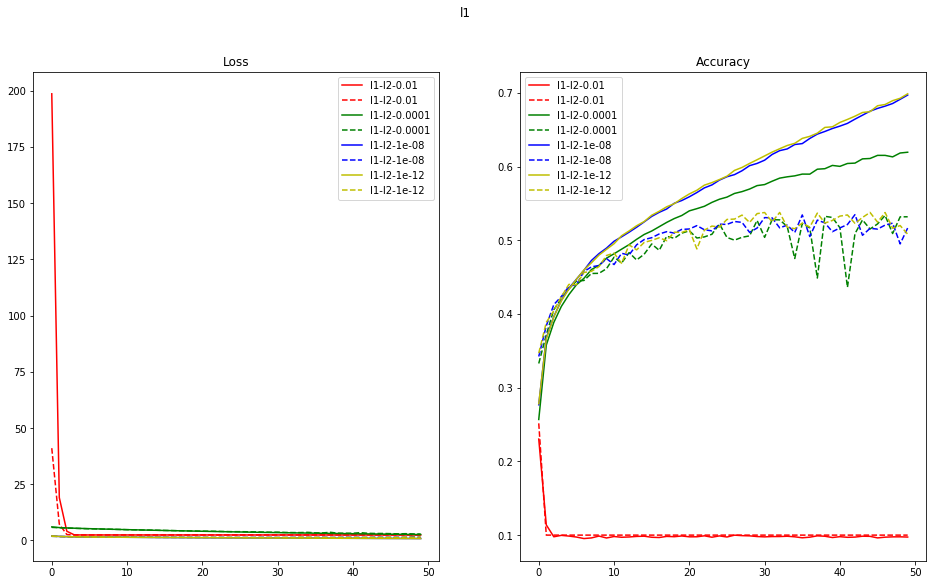

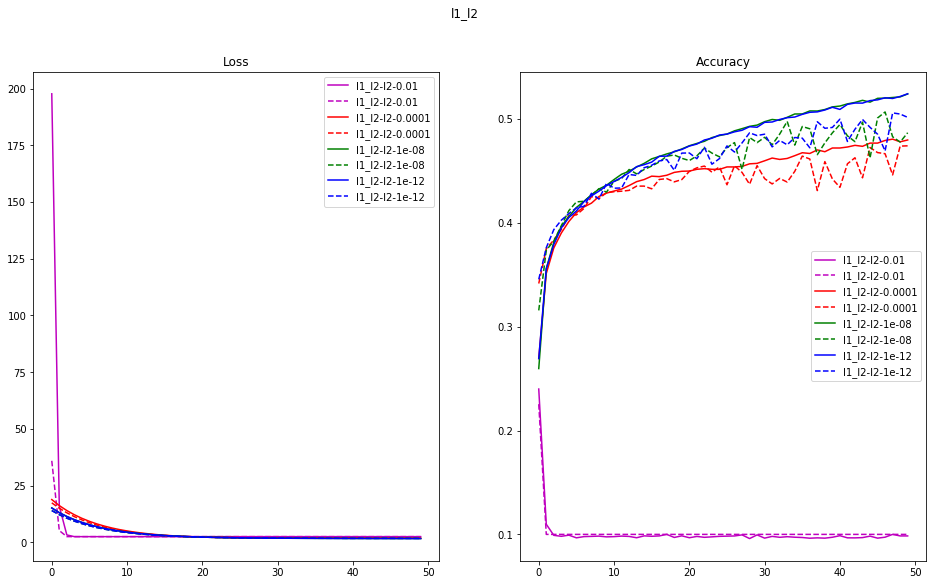

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]


plt.figure(figsize=(16,9))

for regu in REGULAR:
    plt.figure(figsize=(16,9))
    plt.subplot(121).set_title('Loss')
    for i, cond in enumerate(results.keys()):
        if regu == cond.split('-l2')[0]:
            k = i % 5
            plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[k])
            plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[k])
    plt.legend(loc = 'best')
    
    plt.subplot(122).set_title('Accuracy')
    for i, cond in enumerate(results.keys()):
        if regu == cond.split('-l2')[0]:
            k = i % 5
            plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[k])
            plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[k])
    plt.legend(loc = 'best')
    plt.suptitle(regu)
    plt.show()